In [1]:
import os
import sys
import logging
# import glob
# import time
# import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Custom packages
import iXAtom_Class_Physics       as iXC_Physics
import iXAtom_Class_RunParameters as iXC_RunPars
import iXAtom_Class_Detector      as iXC_Detect
import iXAtom_Class_Ramsey        as iXC_Ramsey
import iXAtom_Utilities           as iXUtils

# For inline plots
%matplotlib inline
# Reload IPython extension 'autoreload'
%reload_ext autoreload
# autoreload: Reload all modules (except those excluded by %aimport) automatically now
# autoreload 0: Disable automatic reloading of modules
# autoreload 1: Reload all modules imported with %aimport every time before executing
# autoreload 2: Reload all modules (except those excluded by %aimport) every time before executing
%autoreload 1

%aimport iXAtom_Class_Physics
%aimport iXAtom_Class_RunParameters
%aimport iXAtom_Class_Detector
%aimport iXAtom_Class_Ramsey
%aimport iXAtom_Utilities

logging.disable(level=logging.NOTSET)

# mpl.rcdefaults()

iXUtils.SetDefaultPlotOptions()

In [58]:
WorkDir = 'C:\\Bryns Goodies\\Work-iXAtom\\Data 2019\\December\\15'
Folder  = 'Tracking'
RunNum  = 1

RTFreqFilePath = os.path.join(WorkDir, Folder, 'Run {:02d}'.format(RunNum), 'Track-Run{:02d}-RTFreqData.txt'.format(RunNum))
RTDF = pd.read_csv(RTFreqFilePath, sep='\t')

AIPhaseFilePath = os.path.join(WorkDir, Folder, 'Run {:02d}'.format(RunNum), 'Track-Run{:02d}-Phases.txt'.format(RunNum))
AIDF = pd.read_csv(AIPhaseFilePath, sep='\t')

RTDF.head()
# AIDF.head()

,#Iteration,Date,Time,kIndex,AxisIndex,RTSumFreq1,RTSumFreq2,RTSumFreq3,RTPhase,NFringe
0,1,15/12/2019,19:11:58.360,0.0,2.0,35516749.6,36522518.1,37528434.5,5.090132,0.0
1,2,15/12/2019,19:12:00.226,1.0,2.0,33878963.6,32873287.6,31867526.5,0.143427,-1.0
2,3,15/12/2019,19:12:02.301,0.0,2.0,35516731.7,36522543.2,37528265.4,1.224884,1.0
3,4,15/12/2019,19:12:04.129,1.0,2.0,33879211.1,32873316.1,31867556.3,5.783108,-1.0
4,5,15/12/2019,19:12:06.293,0.0,2.0,35516799.1,36522588.0,37528457.4,3.984132,-1.0


ik = 0, Mean phid = (4.17e-05 +/- 8.3e-05) rad
ik = 1, Mean phid = (-4.40e-05 +/- 1.0e-04) rad


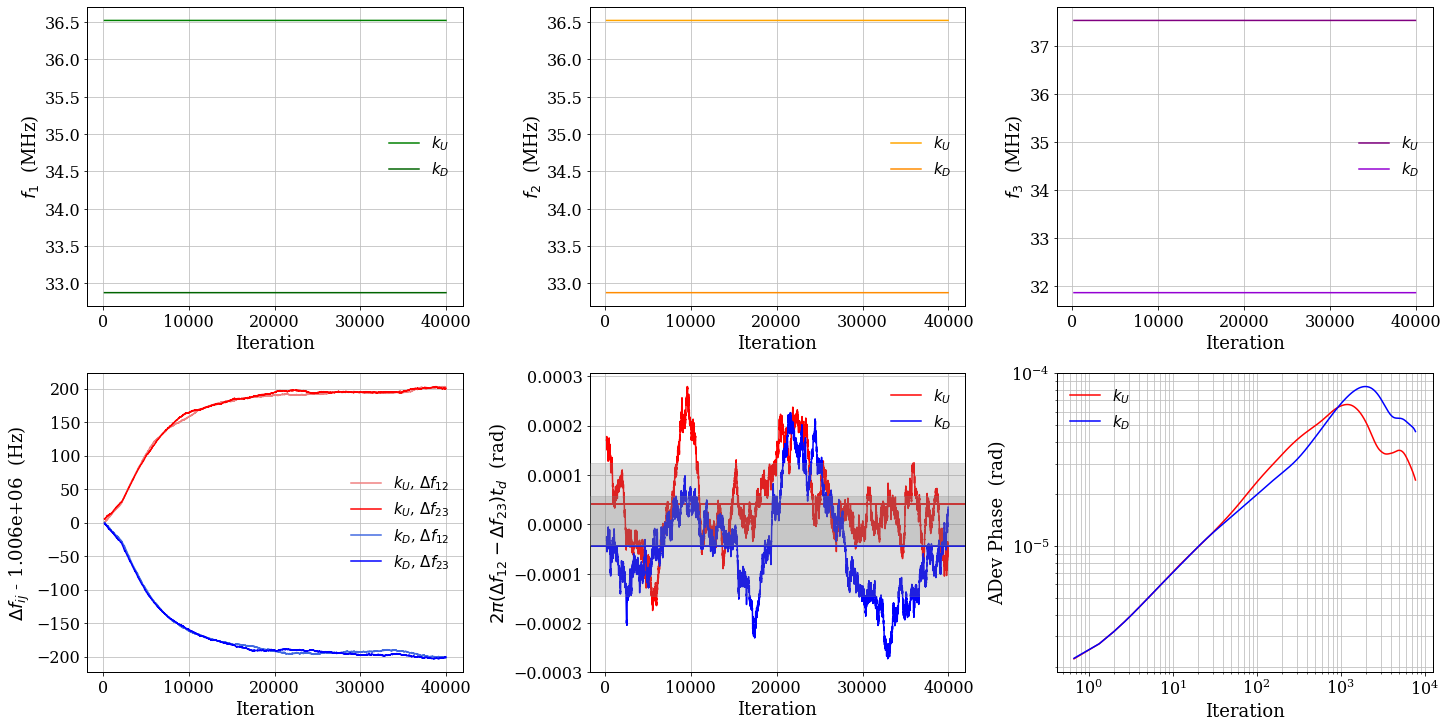

In [46]:
mpl.rc('font', size=16, family='serif')
mpl.rc('axes', titlesize=16, labelsize=18, edgecolor='black', linewidth=1)
mpl.rc('legend', fontsize=15)
mpl.rc('lines', linewidth=1.5, markersize=4)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10), constrained_layout=True)
PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': 'None',
    'Title': 'None', 'xLabel': 'Iteration', 'yLabel': 'RT Freq Diff  (Hz)',
    'LegLabel': 'None', 'Legend': True, 'LegLocation': 'best'}

MovingAvg = True
WinSize = 2000
td = 5.E-6

for ik in range(2):
    RTData = RTDF.loc[RTDF['kIndex'] == ik, ['#Iteration', 'RTSumFreq1', 'RTSumFreq2', 'RTSumFreq3']][100:]
    f1     = RTData['RTSumFreq1']
    f2     = RTData['RTSumFreq2']
    f3     = RTData['RTSumFreq3']
    f12    = f2 - f1 
    f23    = f3 - f2
    f123   = f23 - f12
    
    if MovingAvg:
        f1   = f1.rolling(WinSize, min_periods=1, center=True).mean()
        f2   = f2.rolling(WinSize, min_periods=1, center=True).mean()
        f3   = f3.rolling(WinSize, min_periods=1, center=True).mean()
        f12  = f12.rolling(WinSize, min_periods=1, center=True).mean()
        f23  = f23.rolling(WinSize, min_periods=1, center=True).mean()
        f123 = f123.rolling(WinSize, min_periods=1, center=True).mean()
    
    f1       = f2.to_numpy()
    f2       = f2.to_numpy()
    f3       = f3.to_numpy()    
    f12      = f12.to_numpy()
    f23      = f23.to_numpy()
    f123     = f123.to_numpy()    
    phid     = 2*np.pi*td*f123
    phid_mu  = np.mean(phid)
    phid_sig = np.std(phid)
    print('ik = {}, Mean phid = ({:4.2e} +/- {:3.1e}) rad'.format(ik, phid_mu, phid_sig))

    if ik == 0:
        PlotOpts['Color']    = 'green'
        PlotOpts['xLabel']   = 'Iteration'
        PlotOpts['LegLabel'] = r'$k_U$'
    else:
        PlotOpts['Color']    = 'darkgreen'
        PlotOpts['xLabel']   = 'Iteration'
        PlotOpts['LegLabel'] = r'$k_D$'
    PlotOpts['yLabel']   = r'$f_1$  (MHz)'
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RTData['#Iteration'], f1*1.E-6)

    if ik == 0:
        PlotOpts['Color']  = 'orange'
    else:
        PlotOpts['Color']  = 'darkorange'
    PlotOpts['yLabel']   = r'$f_2$  (MHz)'
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RTData['#Iteration'], f2*1.E-6)

    if ik == 0:
        PlotOpts['Color']  = 'purple'
    else:
        PlotOpts['Color']  = 'darkviolet'
    PlotOpts['yLabel']   = r'$f_3$  (MHz)'
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RTData['#Iteration'], f3*1.E-6)    
    
    if ik == 0:
        PlotOpts['Color']  = 'lightcoral'
        PlotOpts['xLabel'] = 'None'
        legLabel = r'$k_U$, '
        PlotOpts['yLabel']   = r'$\Delta f_{ij}$ - '+'{:5.3e}  (Hz)'.format(f12[0])
    else:
        PlotOpts['Color']  = 'royalblue'
        PlotOpts['xLabel'] = 'Iteration'
        legLabel = r'$k_D$, '
        PlotOpts['yLabel']   = r'$\Delta f_{ij}$ - '+'{:5.3e}  (Hz)'.format(abs(f12[0]))

    PlotOpts['LegLabel'] = legLabel+'$\Delta f_{12}$'
    iXUtils.CustomPlot(axs[1,0], PlotOpts, RTData['#Iteration'], f12 - f12[0])

    if ik == 0:
        PlotOpts['Color'] = 'red'
    else:
        PlotOpts['Color'] = 'blue'
        
    PlotOpts['LegLabel'] = legLabel+'$\Delta f_{23}$'
    iXUtils.CustomPlot(axs[1,0], PlotOpts, RTData['#Iteration'], f23 - f12[0])

    if ik == 0:
        PlotOpts['Color']    = 'red'
        PlotOpts['LegLabel'] = r'$k_U$'
    else:
        PlotOpts['Color'] = 'blue'
        PlotOpts['LegLabel'] = r'$k_D$'

    PlotOpts['yLabel']   = r'$2\pi (\Delta f_{12} - \Delta f_{23}) t_d$  (rad)'
    iXUtils.CustomPlot(axs[1,1], PlotOpts, RTData['#Iteration'], phid)

    axs[1,1].axhline(y=phid_mu, color=PlotOpts['Color'], linestyle='-', linewidth=2)
    axs[1,1].axhspan(phid_mu - phid_sig, phid_mu + phid_sig, color='grey', alpha=0.25, zorder=10)

    PlotOpts['yLabel']   = 'ADev Phase  (rad)'
    (tau, ADev) = iXUtils.ADevTotal(phid, taus='all', rate=1.5)[0:2]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau, ADev, [], LogScale=[True, True])
    
plt.show()

ik = 0, Mean phiRT = (-4.57e-02 +/- 4.89e+00) rad
ik = 1, Mean phiRT = (6.00e-02 +/- 4.87e+00) rad


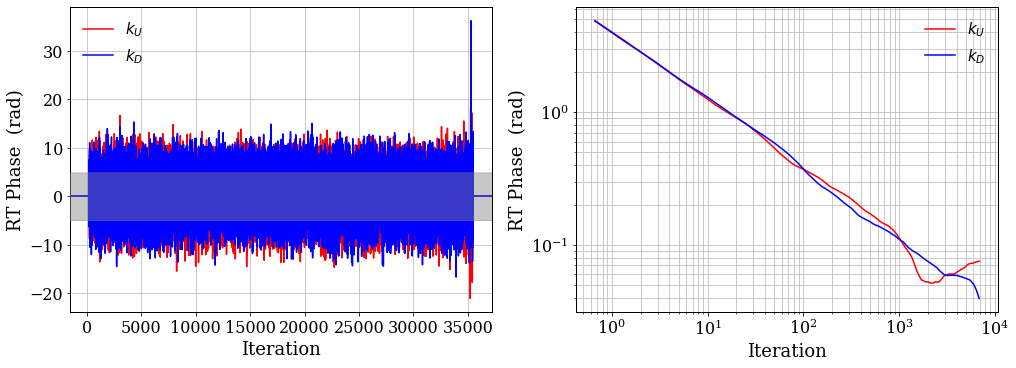

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=False, constrained_layout=True)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': 'None',
    'Title': 'None', 'xLabel': 'Iteration', 'yLabel': 'RT Phase  (rad)',
    'LegLabel': 'None', 'Legend': True, 'LegLocation': 'best'}

MovingAvg = False
WinSize = 5000

for ik in range(2):
    RTData = RTDF.loc[RTDF['kIndex'] == ik, ['#Iteration', 'RTPhase', 'NFringe']][100:]
    phiRT  = RTData['RTPhase'] + 2.*np.pi*RTData['NFringe']

    if MovingAvg:
        phiRT = phiRT.rolling(WinSize, min_periods=1, center=True).mean()

    phiRT     = phiRT.to_numpy()
    phiRT_mu  = np.mean(phiRT)
    phiRT_sig = np.std(phiRT)
    print('ik = {}, Mean phiRT = ({:4.2e} +/- {:4.2e}) rad'.format(ik, phiRT_mu, phiRT_sig))

    if ik == 0:
        PlotOpts['Color']  = 'red'
        PlotOpts['LegLabel'] = r'$k_U$'
    else:
        PlotOpts['Color']  = 'blue'
        PlotOpts['yLabel'] = 'None'
        PlotOpts['LegLabel'] = r'$k_D$'
        
    iXUtils.CustomPlot(axs[0], PlotOpts, RTData['#Iteration'], phiRT)
    if MovingAvg:
        axs[0].fill_between(RTData['#Iteration'], phiRT-dphiRT, phiRT+dphiRT, color='blue', alpha=0.25)
    else:
        axs[0].axhline(phiRT_mu, color=PlotOpts['Color'], linestyle='-', linewidth=2)
        axs[0].axhspan(phiRT_mu-phiRT_sig, phiRT_mu+phiRT_sig, color='grey', alpha=0.25, zorder=10)

    (tau, ADev, ADevErrL, ADevErrU) = iXUtils.ADevTotal(phiRT, taus='all', rate=1.5, tauMax=0.6, computeErr=False)
    iXUtils.CustomPlot(axs[1], PlotOpts, tau, ADev, [], LogScale=[True, True])
    
plt.show()

ik = 0, Mean phiRT = (-4.57e-02 +/- 7.97e-02) rad
ik = 1, Mean phiRT = (5.94e-02 +/- 6.16e-02) rad


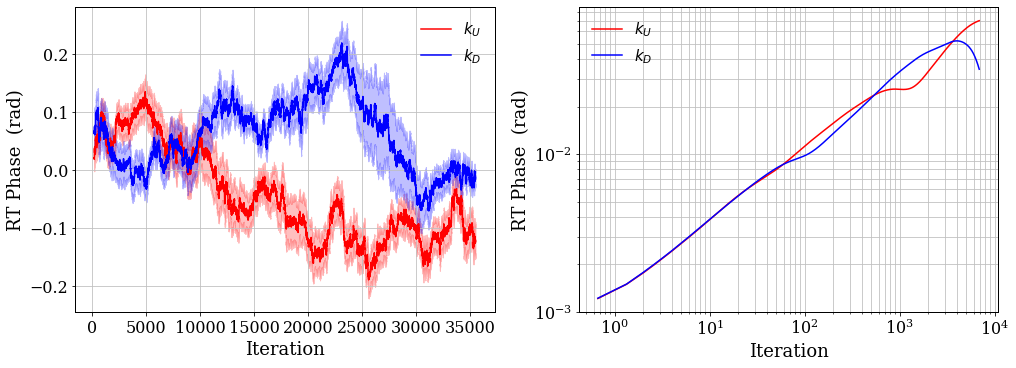

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=False, constrained_layout=True)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': 'None',
    'Title': 'None', 'xLabel': 'Iteration', 'yLabel': 'RT Phase  (rad)',
    'LegLabel': 'None', 'Legend': True, 'LegLocation': 'best'}

MovingAvg = True
WinSize = 4000

for ik in range(2):
    RTData = RTDF.loc[RTDF['kIndex'] == ik, ['#Iteration', 'RTPhase', 'NFringe']][100:]
    phiRT  = RTData['RTPhase'] + 2.*np.pi*RTData['NFringe']

    if MovingAvg:
        phiRT  = phiRT.rolling(WinSize, min_periods=1, center=True).mean()
        dphiRT = phiRT.rolling(WinSize, min_periods=1, center=True).std()

    phiRT     = phiRT.to_numpy()
    phiRT_mu  = np.mean(phiRT)
    phiRT_sig = np.std(phiRT)
    print('ik = {}, Mean phiRT = ({:4.2e} +/- {:4.2e}) rad'.format(ik, phiRT_mu, phiRT_sig))

    if ik == 0:
        PlotOpts['Color']  = 'red'
        PlotOpts['LegLabel'] = r'$k_U$'
    else:
        PlotOpts['Color']  = 'blue'
        PlotOpts['yLabel'] = 'None'
        PlotOpts['LegLabel'] = r'$k_D$'
        
    iXUtils.CustomPlot(axs[0], PlotOpts, RTData['#Iteration'], phiRT)
    if MovingAvg:
        axs[0].fill_between(RTData['#Iteration'], phiRT-dphiRT, phiRT+dphiRT, color=PlotOpts['Color'], alpha=0.25)
    else:
        axs[0].axhline(phiRT_mu, color=PlotOpts['Color'], linestyle='-', linewidth=2)
        axs[0].axhspan(phiRT_mu-phiRT_sig, phiRT_mu+phiRT_sig, color='grey', alpha=0.25, zorder=10)

    (tau, ADev) = iXUtils.ADevTotal(phiRT, taus='all', rate=1.5)[0:2]
    iXUtils.CustomPlot(axs[1], PlotOpts, tau, ADev, [], LogScale=[True, True])

plt.show()

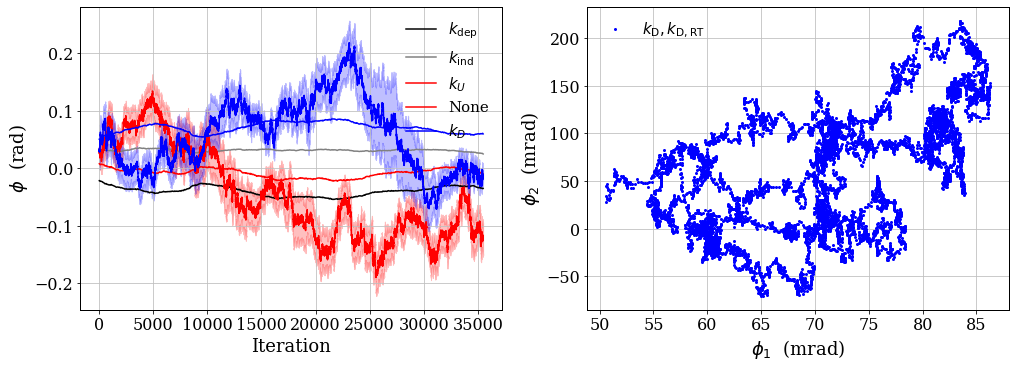

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5), constrained_layout=True)

PlotOpts = {'Color': 'black', 'Linestyle': '-', 'Marker': 'None',
    'Title': 'None', 'xLabel': 'Iteration', 'yLabel': r'$\phi$  (rad)',
    'LegLabel': r'$k_{\rm dep}$', 'Legend': True, 'LegLocation': 'best'}

AIData = AIDF[['#Iteration', 'kUPhaseCent', 'kDPhaseCent', 'kIndPhaseCent', 'kDepPhaseCent']]
RTData = [RTDF.loc[RTDF['kIndex'] == ik, ['#Iteration', 'kIndex', 'RTPhase', 'NFringe']] for ik in range(2)]

MovingAvg = True
AIWinSize = 1000
RTWinSize = 4*AIWinSize

phikU   = AIData['kUPhaseCent']
phikD   = AIData['kDPhaseCent']
phikDep = AIData['kDepPhaseCent']
phikInd = AIData['kIndPhaseCent']
phiRTkU = RTData[0]['RTPhase'] + 2.*np.pi*RTData[0]['NFringe']
phiRTkD = RTData[1]['RTPhase'] + 2.*np.pi*RTData[1]['NFringe']

if MovingAvg:
    phikU    = phikU.rolling(AIWinSize, min_periods=1, center=True).mean()
    phikD    = phikD.rolling(AIWinSize, min_periods=1, center=True).mean()
    phikDep  = phikDep.rolling(AIWinSize, min_periods=1, center=True).mean()
    phikInd  = phikInd.rolling(AIWinSize, min_periods=1, center=True).mean()
    phiRTkU  = phiRTkU.rolling(RTWinSize, min_periods=1, center=True).mean()
    dphiRTkU = phiRTkU.rolling(RTWinSize, min_periods=1, center=True).std()
    phiRTkD  = phiRTkD.rolling(RTWinSize, min_periods=1, center=True).mean()
    dphiRTkD = phiRTkD.rolling(RTWinSize, min_periods=1, center=True).std()

PlotOpts['Color']    = 'black'
PlotOpts['LegLabel'] = r'$k_{\rm dep}$'
iXUtils.CustomPlot(axs[0], PlotOpts, AIData['#Iteration'], phikDep)

PlotOpts['Color']    = 'grey'
PlotOpts['LegLabel'] = r'$k_{\rm ind}$'
iXUtils.CustomPlot(axs[0], PlotOpts, AIData['#Iteration'], phikInd)

PlotOpts['Color']    = 'red'
PlotOpts['LegLabel'] = r'$k_U$'
iXUtils.CustomPlot(axs[0], PlotOpts, AIData['#Iteration'], phikU)

PlotOpts['LegLabel'] = 'None'
PlotOpts['Legend']   = False
iXUtils.CustomPlot(axs[0], PlotOpts, RTData[0]['#Iteration'], phiRTkU)

PlotOpts['Color']    = 'blue'
PlotOpts['LegLabel'] = r'$k_D$'
PlotOpts['Legend']   = True
iXUtils.CustomPlot(axs[0], PlotOpts, AIData['#Iteration'], phikD)

PlotOpts['LegLabel'] = 'None'
PlotOpts['Legend']   = False
iXUtils.CustomPlot(axs[0], PlotOpts, RTData[1]['#Iteration'], phiRTkD)

if MovingAvg:
    axs[0].fill_between(RTData[0]['#Iteration'], phiRTkU-dphiRTkU, phiRTkU+dphiRTkU, color='red', alpha=0.25)
    axs[0].fill_between(RTData[1]['#Iteration'], phiRTkD-dphiRTkD, phiRTkD+dphiRTkD, color='blue', alpha=0.25)

PlotOpts['Color']     = 'grey'
PlotOpts['Linestyle'] = 'None'
PlotOpts['Marker']    = '.'
PlotOpts['xLabel']    = r'$\phi_1$  (mrad)'
PlotOpts['yLabel']    = r'$\phi_2$  (mrad)'
PlotOpts['LegLabel']  = r'$k_{\rm dep}, k_{\rm ind}$' 
PlotOpts['Legend']    = True
# iXUtils.CustomPlot(axs[1], PlotOpts, phikDep*1.E3, phikInd*1.E3)

# PlotOpts['Color']     = 'black'
# PlotOpts['LegLabel']  = r'$k_{\rm U}, k_{\rm D}$'
# iXUtils.CustomPlot(axs[1], PlotOpts, phikU*1.E3, phikD*1.E3)

# PlotOpts['Color']     = 'red'
# PlotOpts['LegLabel']  = r'$k_{\rm U}, k_{\rm U,RT}$' 
# iXUtils.CustomPlot(axs[1], PlotOpts, phikU*1.E3, phiRTkU[::2]*1.E3)

PlotOpts['Color']     = 'blue'
PlotOpts['LegLabel']  = r'$k_{\rm D}, k_{\rm D,RT}$'
iXUtils.CustomPlot(axs[1], PlotOpts, phikD*1.E3, phiRTkD[::2]*1.E3)

plt.show()

In [119]:
RTData[1].head(10)

,#Iteration,kIndex,RTPhase,NFringe
1,2,1.0,0.502379,0.0
3,4,1.0,2.624258,0.0
5,6,1.0,2.660690,0.0
7,8,1.0,4.535981,-1.0
9,10,1.0,3.737544,0.0
11,12,1.0,2.756180,-1.0
13,14,1.0,2.160228,3.0
15,16,1.0,4.748054,-1.0
17,18,1.0,3.079850,-2.0
19,20,1.0,1.666287,-1.0


In [120]:
AIData.head(10)

,#Iteration,kUPhaseCent,kDPhaseCent,kIndPhaseCent,kDepPhaseCent
0,4,0.000000,0.000000,0.000000,0.000000
1,8,0.005235,0.041957,0.023596,-0.018361
2,12,-0.037956,0.052821,0.007432,-0.045388
3,16,-0.042669,0.066407,0.011869,-0.054538
4,20,0.025500,0.142285,0.083893,-0.058392
5,24,0.050100,0.099055,0.074578,-0.024477
6,28,0.038853,0.066797,0.052825,-0.013972
7,32,0.018878,0.058893,0.038885,-0.020007
8,36,0.050310,0.018603,0.034457,0.015853
9,40,0.037064,0.041005,0.039034,-0.001971


In [131]:
AIData.merge(RTData[1], how='inner', on='#Iteration').head(10)

,#Iteration,kUPhaseCent,kDPhaseCent,kIndPhaseCent,kDepPhaseCent,kIndex,RTPhase,NFringe
0,4,0.000000,0.000000,0.000000,0.000000,1.0,2.624258,0.0
1,8,0.005235,0.041957,0.023596,-0.018361,1.0,4.535981,-1.0
2,12,-0.037956,0.052821,0.007432,-0.045388,1.0,2.756180,-1.0
3,16,-0.042669,0.066407,0.011869,-0.054538,1.0,4.748054,-1.0
4,20,0.025500,0.142285,0.083893,-0.058392,1.0,1.666287,-1.0
5,24,0.050100,0.099055,0.074578,-0.024477,1.0,0.090888,-1.0
6,28,0.038853,0.066797,0.052825,-0.013972,1.0,5.337486,-1.0
7,32,0.018878,0.058893,0.038885,-0.020007,1.0,4.461200,-2.0
8,36,0.050310,0.018603,0.034457,0.015853,1.0,6.060375,-1.0
9,40,0.037064,0.041005,0.039034,-0.001971,1.0,1.819685,-1.0
